In [106]:
# Montamos el drive

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
# Importamos el archivo ready_df que es el resultado del Preprocesamiento y del Análisis de Sentimientos previo.

import pandas as pd

try:
    ready_df = pd.read_excel('/content/drive/MyDrive/CAPSTONE/ENTREGA/ready_df.xlsx', index_col=None)

    # Verificar si ready_df es un DataFrame
    # if isinstance(ready_df, pd.DataFrame):
    #     print("ready_df es un DataFrame")
    # else:
    #     print("ready_df NO es un DataFrame")

except ValueError as e:
    print(f'Error de formato del archivo Excel: {e}')
except FileNotFoundError as e:
    print(f'Error al encontrar el archivo: {e}')
except pd.errors.ParserError as e:
    print(f'Error al analizar el archivo Excel: {e}')
except Exception as e:
    print(f'Error desconocido: {e}')

## Naive Bayes Classifier:

A simple probabilistic model that classifies text based on the likelihood of sentiment categories (positive, negative, neutral). It's fast but less effective for more complex sentences.

For this simple Naive Bayes sentiment analysis task, we will focus on the Texto column for input text and use one of the sentiment labels (for example, textblob_custom_sentiment) as the target variable.

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# We'll use 'Texto' for the text and 'textblob_sentiment' for labels

################
# CAMBIAR AQUÍ LA VARIABLE QUE SE QUIERE PASAR A NAIVE BAYES. TIENE QUE SER UNA VARIABLE DE POLARIDAD -1 / 1
################
ready_df['sentiment'] = ready_df['textblob_sentiment'].apply(lambda x: 1 if x > 0 else 0)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ready_df['Texto'], ready_df['sentiment'], test_size=0.3, random_state=42)

# Vectorizing the text data (Bag of Words model)
vectorizer = CountVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vectorized, y_train)

# Predictions
y_pred = nb_model.predict(X_test_vectorized)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep

(0.9111969111969112,
 '              precision    recall  f1-score   support\n\n           0       0.92      0.97      0.94      3684\n           1       0.89      0.74      0.81      1237\n\n    accuracy                           0.91      4921\n   macro avg       0.90      0.85      0.87      4921\nweighted avg       0.91      0.91      0.91      4921\n')

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for the specific character you're analyzing, e.g., "John"
character_name = "walter"
char_df = ready_df[ready_df['Personaje'] == character_name]

In [110]:
char_df['naive_bayes_prediction'] = nb_model.predict(vectorizer.transform(char_df['Texto']))

# Group by 'Temporada' and 'Episodio', and calculate the mean of 'naive_bayes_prediction'
episode_sentiment = char_df.groupby(['Temporada', 'Episodio'])['naive_bayes_prediction'].mean()

# Check the result
print(episode_sentiment)

Temporada  Episodio
1          1           0.301205
           2           0.415584
           3           0.142857
           4           0.142857
           5           0.370370
           6           0.287234
           7           0.323529
2          1           0.226415
           2           0.086957
           3           0.361702
           4           0.346154
           5           0.352941
           6           0.552632
           7           0.245902
           8           0.180328
           9           0.237624
           10          0.272727
           11          0.163934
           12          0.333333
           13          0.325581
3          1           0.333333
           2           0.285714
           3           0.107143
           4           0.229508
           5           0.218750
           6           0.253968
           7           0.289474
           8           0.329268
           9           0.148148
           10          0.245098
           11       

<ipython-input-110-265d9a131f10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_df['naive_bayes_prediction'] = nb_model.predict(vectorizer.transform(char_df['Texto']))


Temporada  Episodio
1          1           0.268908
           2           0.354167
           3           0.177515
           4           0.295775
           5           0.297872
                         ...   
5          12          0.225058
           13          0.184000
           14          0.133829
           15          0.120000
           16          0.149425
Name: naive_bayes_prediction, Length: 62, dtype: float64


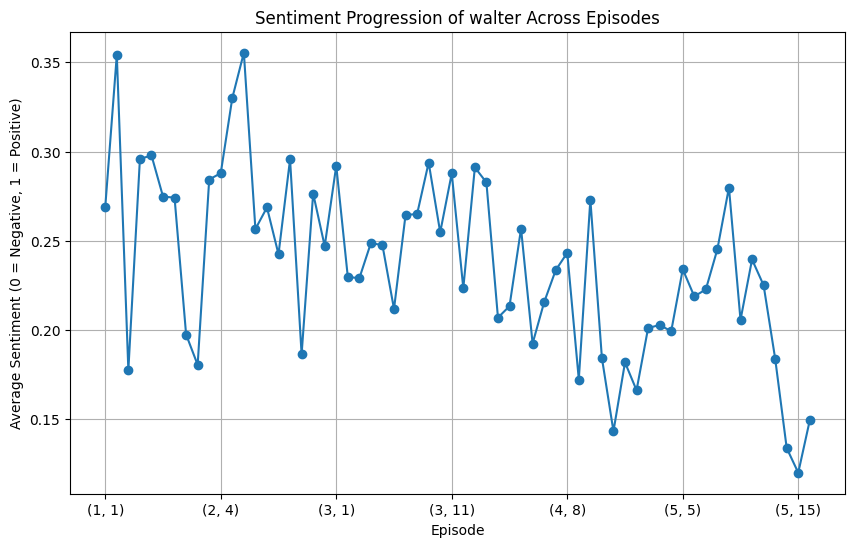

In [111]:
import matplotlib.pyplot as plt

ready_df['naive_bayes_prediction'] = nb_model.predict(vectorizer.transform(ready_df['Texto']))

# Group by 'Temporada' and 'Episodio', and calculate the mean of 'naive_bayes_prediction'
episode_sentiment = ready_df.groupby(['Temporada', 'Episodio'])['naive_bayes_prediction'].mean()

# Check the result
print(episode_sentiment)


# Plot the sentiment progression across episodes
plt.figure(figsize=(10, 6))
episode_sentiment.plot(kind='line', marker='o')
plt.title(f"Sentiment Progression of {character_name} Across Episodes")
plt.xlabel("Episode")
plt.ylabel("Average Sentiment (0 = Negative, 1 = Positive)")
plt.grid(True)
plt.show()

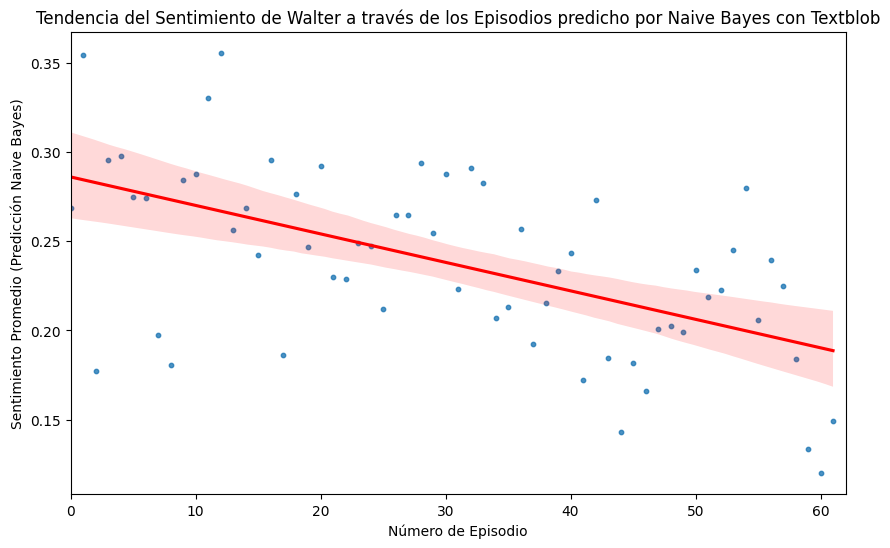

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Resetear el índice de los datos agrupados para que 'Temporada' y 'Episodio' sean columnas accesibles
episode_sentiment = episode_sentiment.reset_index()

# Crear un número de episodio secuencial basado en la longitud del DataFrame
episode_sentiment['Episode_Number'] = range(len(episode_sentiment))

# Establecer el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar una línea de sentimiento de los episodios con una línea de tendencia usando Seaborn
sns.regplot(x='Episode_Number', y='naive_bayes_prediction', data=episode_sentiment,
            scatter_kws={"s": 10}, line_kws={"color": "red"})

# Añadir etiquetas y título
plt.xlabel('Número de Episodio')
plt.ylabel('Sentimiento Promedio (Predicción Naive Bayes)')
plt.title('Tendencia del Sentimiento de Walter a través de los Episodios predicho por Naive Bayes con Textblob')

plt.xlim(0, len(episode_sentiment))
plt.show()